# Feature Selection Techniques - Recursive Feature Elimination and cross-validated selection (RFECV)

RFECV differs from Recursive Feature Elimination (RFE) in the function selection process in that it indicates the OPTIMAL NUMBER OF VARIABLES and not the designated number of best variables.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
np.random.seed(123)

In [2]:
##  colorful prints
def black(text):
     print('\033[30m', text, '\033[0m', sep='')  
def red(text):
     print('\033[31m', text, '\033[0m', sep='')  
def green(text):
     print('\033[32m', text, '\033[0m', sep='')  
def yellow(text):
     print('\033[33m', text, '\033[0m', sep='')  
def blue(text):
     print('\033[34m', text, '\033[0m', sep='') 
def magenta(text):
     print('\033[35m', text, '\033[0m', sep='')  
def cyan(text):
     print('\033[36m', text, '\033[0m', sep='')  
def gray(text):
     print('\033[90m', text, '\033[0m', sep='')

data source: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [3]:
df = pd.read_csv ('/home/wojciech/Pulpit/6/Breast_Cancer_Wisconsin.csv')
green(df.shape)
df.head(3)


(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


### Deleting unneeded columns

In [4]:
df['concave_points_worst'] = df['concave points_worst']
df['concave_points_se'] = df['concave points_se']
df['concave_points_mean'] = df['concave points_mean']

del df['Unnamed: 32']
del df['diagnosis']
del df['id']

In [5]:
df.isnull().sum()

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
concave_points_worst       0
concave_points_se          0
concave_points_mean        0
dtype: int64

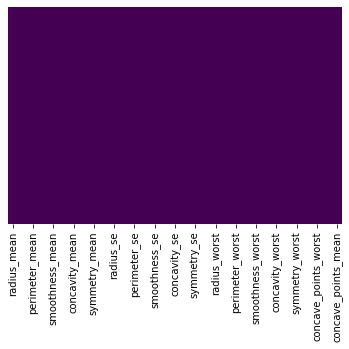

In [6]:
import seaborn as sns

sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Deletes duplicates
there were no duplicates

In [7]:
green(df.shape)
df.drop_duplicates(keep='first', inplace=True)
blue(df.shape)

(569, 33)
(569, 33)


In [8]:
blue(df.dtypes)

radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst      

In [9]:
df.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'concave_points_worst',
       'concave_points_se', 'concave_points_mean'],
      dtype='object')

### We choose the continuous variable - compactness_mean


max: 0.3454
min: 0.01938


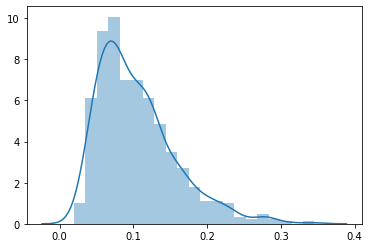

In [10]:
print('max:',df['compactness_mean'].max())
print('min:',df['compactness_mean'].min())

sns.distplot(np.array(df['compactness_mean']))

# Recursive Feature Elimination and cross-validated selection (RFECV)

In [11]:
X = df.drop('compactness_mean', axis=1) 
y = df['compactness_mean']  

## I set the minimum number of variables that will remain in the model

In [12]:
min_v = 2

OPTIMAL Number of selected functions:   15

The mask of selected features:  [ True  True  True False False  True False  True False  True False  True
 False False False False False False False  True  True  True False False
  True  True  True  True False  True False False]

The feature ranking: [ 1  1  1  2  9  1  3  1 13  1  7  1 11 17  8 10 16 14 18  1  1  1 12  6
  1  1  1  1  5  1 15  4]

The external estimator: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
Optimal number of features : 15


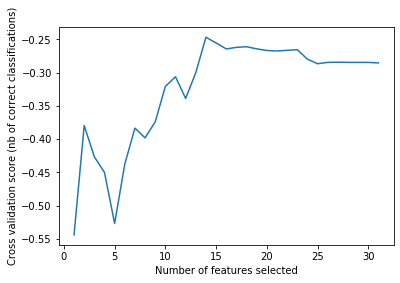

In [26]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
RCV = RFECV(estimator, step=1,min_features_to_select=min_v, cv=5)
RCV = RCV.fit(X, y)
RCV.support_


print('The mask of selected features: ',RCV.support_)
print()
print('The feature ranking:',RCV.ranking_)
print()
print('The external estimator:',RCV.estimator_)



print("Optimal number of features : %d" % RCV.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(RCV.grid_scores_) + 1), RCV.grid_scores_)
plt.show()

The RFECV algorithm checked all combinations and showed on the graph that the number of 15 variables was optimal.

### Metoda zip na wyświetlenie rankingu cech

In [14]:
PPS = RCV.ranking_

KOT_MIC = dict(zip(df, PPS))
KOT_sorted_keys_MIC = sorted(KOT_MIC, key=KOT_MIC.get, reverse=True)

for r in KOT_sorted_keys_MIC:
    print (r, KOT_MIC[r])

symmetry_se 18
area_se 17
concavity_se 16
concave_points_worst 15
concave points_se 14
symmetry_mean 13
perimeter_worst 12
perimeter_se 11
compactness_se 10
smoothness_mean 9
smoothness_se 8
radius_se 7
area_worst 6
symmetry_worst 5
concave_points_se 4
concavity_mean 3
area_mean 2
radius_mean 1
texture_mean 1
perimeter_mean 1
compactness_mean 1
concave points_mean 1
fractal_dimension_mean 1
texture_se 1
fractal_dimension_se 1
radius_worst 1
texture_worst 1
smoothness_worst 1
compactness_worst 1
concavity_worst 1
concave points_worst 1
fractal_dimension_worst 1


In [15]:
new_cols = X.columns[RCV.support_]

In [16]:
df2 = df[new_cols]
blue(df2.shape)
df2.head(3)

(569, 15)


,radius_mean,texture_mean,perimeter_mean,concavity_mean,symmetry_mean,radius_se,perimeter_se,radius_worst,texture_worst,perimeter_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,concave_points_worst
0,17.99,10.38,122.8,0.3001,0.2419,1.0950,8.589,25.38,17.33,184.6,0.6656,0.7119,0.2654,0.4601,0.2654
1,20.57,17.77,132.9,0.0869,0.1812,0.5435,3.398,24.99,23.41,158.8,0.1866,0.2416,0.1860,0.2750,0.1860
2,19.69,21.25,130.0,0.1974,0.2069,0.7456,4.585,23.57,25.53,152.5,0.4245,0.4504,0.2430,0.3613,0.2430


## We're adding a result variable

In [17]:
df2['compactness_mean'] = df['compactness_mean']
df2.head(3)

,radius_mean,texture_mean,perimeter_mean,concavity_mean,symmetry_mean,radius_se,perimeter_se,radius_worst,texture_worst,perimeter_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,concave_points_worst,compactness_mean
0,17.99,10.38,122.8,0.3001,0.2419,1.0950,8.589,25.38,17.33,184.6,0.6656,0.7119,0.2654,0.4601,0.2654,0.27760
1,20.57,17.77,132.9,0.0869,0.1812,0.5435,3.398,24.99,23.41,158.8,0.1866,0.2416,0.1860,0.2750,0.1860,0.07864
2,19.69,21.25,130.0,0.1974,0.2069,0.7456,4.585,23.57,25.53,152.5,0.4245,0.4504,0.2430,0.3613,0.2430,0.15990


The Backward Elimination algorithm stated that reducing variables does not improve the model. Therefore, the number of variables was left unchanged.

### OLS linear regression model for variables before reduction

In [18]:
blue(df.shape)

(569, 33)


In [19]:
X1 = df.drop('compactness_mean', axis=1) 
y1 = df['compactness_mean']  

In [20]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = sm.OLS(y1, sm.add_constant(X1))
model_fit = model.fit()

print('R2: %.6f' % model_fit.rsquared)
#blue(model_fit.summary())

R2: 0.980200


### OLS linear regression model for variables after reduction

In [21]:
blue(df2.shape)

(569, 16)


In [22]:
X2 = df2.drop('compactness_mean', axis=1) 
y2 = df2['compactness_mean']  

In [23]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

model = sm.OLS(y2, sm.add_constant(X2))
model_fit = model.fit()

print('R2: %.6f' % model_fit.rsquared)
#blue(model_fit.summary())
red('The reduction of dimensions caused the deterioration of the models properties')

R2: 0.960155
The reduction of dimensions caused the deterioration of the models properties
